In [ ]:
!pip install yfinance arch ta pandas numpy matplotlib scikit-learn pmdarima

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.3/981.3 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 689.1/689.1 kB 41.3 MB/s eta 0:00:00
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=02f7016cecef483219a700d5626735d1830487780bd7394f55fead3887e03191
  Stored in directory: /root/.cache/pip/wheels/5c/a1/5f/c6b85a7d9452057be4ce68a8e45d77ba34234a6d46581777c6
Successfully built ta


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np

ticker = "PETR4.SA" #petrobras
df = yf.download(ticker, start="2010-01-01", end="2025-01-01")
df = df[['Close','Volume']]
df.dropna(inplace=True)

# retorno log
df['ret_log'] = np.log(df['Close'] / df['Close'].shift(1))

df.dropna(inplace=True)
df.head()


/tmp/ipython-input-3231674897.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start="2010-01-01", end="2025-01-01")
[*********************100%***********************]  1 of 1 completed


Price,Close,Volume,ret_log
Ticker,PETR4.SA,PETR4.SA,
Date,,,
2010-01-05,8.310829,21396400,-0.008612
2010-01-06,8.423138,18720600,0.013423
2010-01-07,8.344522,10964600,-0.009377
2010-01-08,8.299596,14624200,-0.005399
2010-01-11,8.272642,15317700,-0.003253


##Visualização inicial dos dados

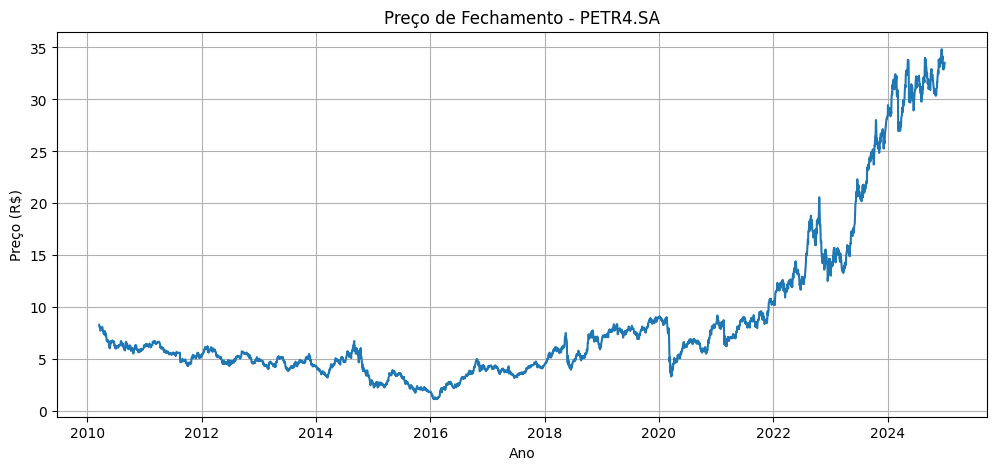

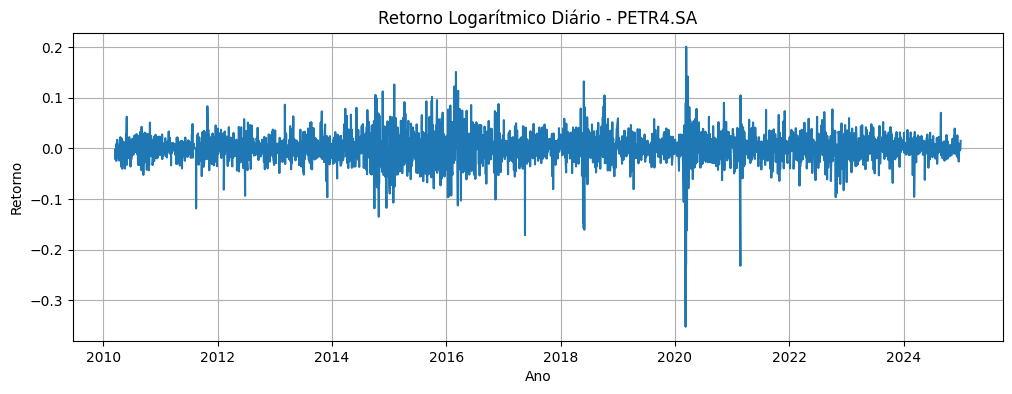

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(df['Close'])
plt.title("Preço de Fechamento - " + ticker)
plt.xlabel("Ano")
plt.ylabel("Preço (R$)")
plt.grid(True)
plt.show()

plt.figure(figsize=(12,4))
plt.plot(df['ret_log'])
plt.title("Retorno Logarítmico Diário - " + ticker)
plt.xlabel("Ano")
plt.ylabel("Retorno")
plt.grid(True)
plt.show()


#indicadores tecnicos

In [ ]:
import ta

close_prices = df[('Close', ticker)]

df['rsi'] = ta.momentum.rsi(close_prices, window=14)
df['ema_20'] = ta.trend.ema_indicator(close_prices, window=20) #tendencia de curto prazo
df['ema_50'] = ta.trend.ema_indicator(close_prices, window=50) #tendencia moderada

macd = ta.trend.MACD(close=close_prices)
df['macd'] = macd.macd()
df['macd_signal'] = macd.macd_signal()
df['macd_hist'] = macd.macd_diff()

df.dropna(inplace=True)

In [ ]:
from pmdarima import auto_arima

arima_model = auto_arima(df['ret_log'], seasonal=False, trace=False)
arima_forecast = arima_model.predict(n_periods=30)
arima_forecast[:5]


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


,0
3674,-0.002128
3675,0.000771
3676,0.000049
3677,-0.000160
3678,0.000936


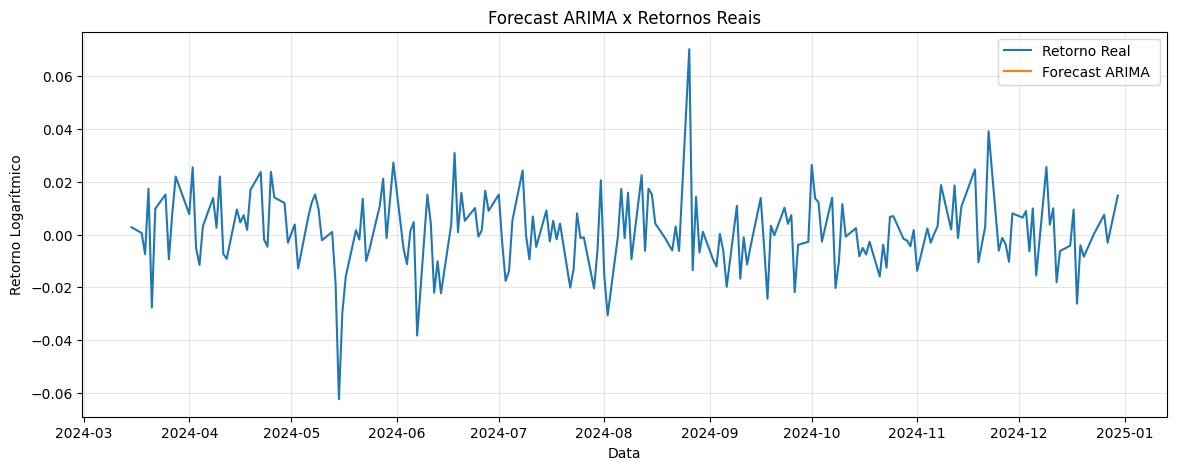

In [20]:
arima_pred = pd.Series(arima_forecast,
                       index=pd.date_range(start=df.index[-1] + pd.Timedelta(days=1),
                                           periods=30, freq='B'))

plt.figure(figsize=(14,5))
plt.plot(df['ret_log'].iloc[-200:], label='Retorno Real')
plt.plot(arima_pred, label='Forecast ARIMA ')
plt.title("Forecast ARIMA x Retornos Reais")
plt.xlabel("Data")
plt.ylabel("Retorno Logarítmico")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


In [ ]:
from arch import arch_model

garch_model = arch_model(df['ret_log']*100, vol='GARCH', p=1, q=1, dist='normal')
garch_result = garch_model.fit(update_freq=10, disp='off')

print(garch_result.summary())


                     Constant Mean - GARCH Model Results                      
Dep. Variable:                ret_log   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -8552.42
Distribution:                  Normal   AIC:                           17112.8
Method:            Maximum Likelihood   BIC:                           17137.7
                                        No. Observations:                 3674
Date:                Fri, Dec 05 2025   Df Residuals:                     3673
Time:                        02:08:16   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.0719  3.920e-02      1.835  6.647e-02 [-4.89

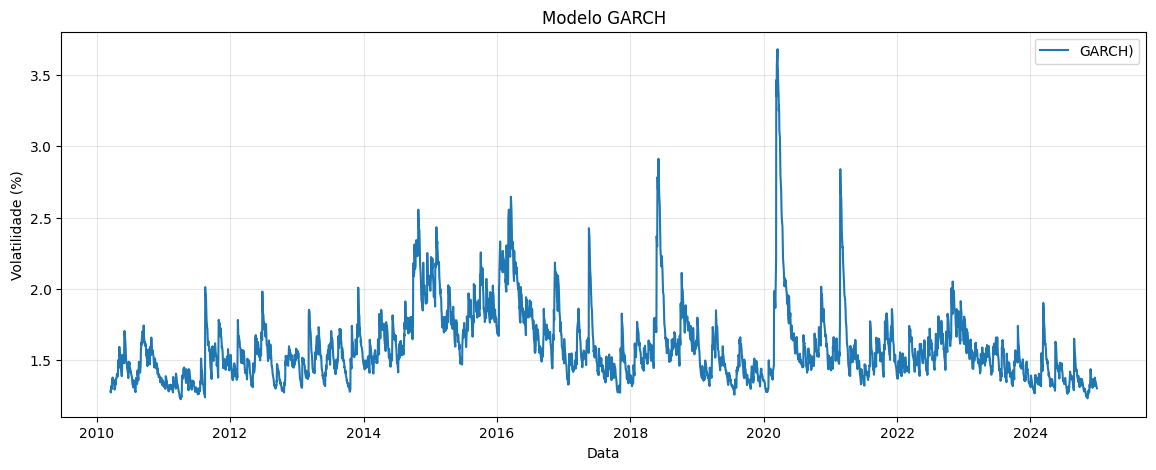

In [17]:
import matplotlib.pyplot as plt

cond_vol = np.sqrt(garch_result.conditional_volatility)

plt.figure(figsize=(14,5))
plt.plot(df.index, cond_vol, label='GARCH)')
plt.title("Modelo GARCH")
plt.xlabel("Data")
plt.ylabel("Volatilidade (%)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


In [ ]:
def create_lags(series, nlags=10):
    df_lags = pd.DataFrame(series)
    for i in range(1, nlags+1):
        df_lags[f'lag_{i}'] = df_lags['ret_log'].shift(i)
    return df_lags

lags = create_lags(df['ret_log'])
data_ml = pd.concat([lags, df[['rsi','ema_20','ema_50','macd','macd_signal','Volume']]], axis=1) #dataset
data_ml.dropna(inplace=True)


In [ ]:
train_size = int(len(data_ml)*0.85)
train = data_ml.iloc[:train_size]
test = data_ml.iloc[train_size:]

X_train = train.drop('ret_log', axis=1)
y_train = train['ret_log']
X_test = test.drop('ret_log', axis=1)
y_test = test['ret_log']


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error


X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

model_rf = RandomForestRegressor(n_estimators=300)
model_rf.fit(X_train, y_train)

pred_rf = model_rf.predict(X_test)

rmse_rf = (mean_squared_error(y_test, pred_rf)**0.5)
rmse_rf

0.01524036846756437

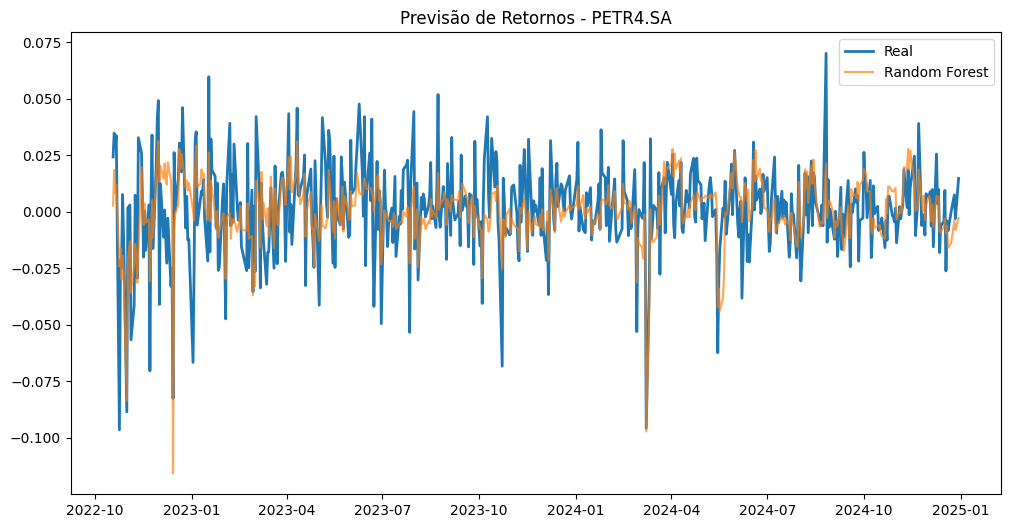

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(y_test.index, y_test, label='Real', linewidth=2)
plt.plot(y_test.index, pred_rf, label='Random Forest', alpha=0.7)
plt.title(f"Previsão de Retornos - {ticker}")
plt.legend()
plt.show()
